In [20]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import Counter, OrderedDict
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
EXTENSIONS = ['.jpg', '.png']

def load_image(file):
    return Image.open(file)

def is_image(filename):
    return any(filename.endswith(ext) for ext in EXTENSIONS)

def is_label(filename):
    return filename.endswith("_labelTrainIds.png")

def image_path_city(root, name):
    return os.path.join(root, f'{name}')


In [3]:
class cityscapes(Dataset):

    def __init__(self, root, co_transform=None, subset='train'):
        self.images_root = os.path.join(root, 'leftImg8bit/')
        self.labels_root = os.path.join(root, 'gtFine/')
        
        self.images_root += subset
        self.labels_root += subset

        print (self.images_root)
        #self.filenames = [image_basename(f) for f in os.listdir(self.images_root) if is_image(f)]
        self.filenames = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.images_root)) for f in fn if is_image(f)]
        self.filenames.sort()

        #[os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(".")) for f in fn]
        #self.filenamesGt = [image_basename(f) for f in os.listdir(self.labels_root) if is_image(f)]
        self.filenamesGt = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.labels_root)) for f in fn if is_label(f)]
        self.filenamesGt.sort()

        self.co_transform = co_transform # ADDED THIS


    def __getitem__(self, index):
        filename = self.filenames[index]
        filenameGt = self.filenamesGt[index]

        with open(image_path_city(self.images_root, filename), 'rb') as f:
            image = load_image(f).convert('RGB')
        with open(image_path_city(self.labels_root, filenameGt), 'rb') as f:
            label = load_image(f).convert('P')

        if self.co_transform is not None:
            image = self.co_transform(image)
            label = self.co_transform(label)
            
            # image, label = self.co_transform(image, label)

        return image, label

    def __len__(self):
        return len(self.filenames)


In [9]:
# Example data and labels
dataset_path = 'D:\\COMPUTER_DEPARTMENT\\3RD_YEAR\\AML\\AML_Project_v2.0\\Dataset\\leftImg8bit_trainvaltest'
transform = transforms.ToTensor()

dataset = cityscapes(dataset_path,co_transform=transform,subset='train')
# print(dataset.__len__())
loader = DataLoader(dataset, batch_size=64, shuffle=True)

label_counts = Counter()
print('Done with 0 %',end='\r')
i =0
for _, labels in loader:
    print(f'Done with {len(labels)*i*100/dataset.__len__()} %',end='\r')
    i+=1
    label_counts.update(labels.view(-1).tolist() )
print('\n')
print(label_counts)
    

D:\COMPUTER_DEPARTMENT\3RD_YEAR\AML\AML_Project_v2.0\Dataset\leftImg8bit_trainvaltest\leftImg8bit/train
Done with 47.9327731092437 %%%

Counter({0.0: 2036048947, 0.007843137718737125: 1259773719, 0.0313725508749485: 878732748, 1.0: 718433804, 0.05098039284348488: 386502900, 0.003921568859368563: 336030285, 0.03921568766236305: 221459205, 0.019607843831181526: 67771815, 0.04313725605607033: 67202381, 0.03529411926865578: 63964778, 0.01568627543747425: 48487347, 0.0117647061124444: 36211195, 0.027450980618596077: 30522367, 0.07058823853731155: 22849760, 0.054901961237192154: 14775005, 0.05882352963089943: 12995799, 0.062745101749897: 12863932, 0.0235294122248888: 11510397, 0.0470588244497776: 7444907, 0.06666667014360428: 5445909})


In [10]:
def transform_key(key):
    newkey = int(key * 255)
    return newkey

# Create a new Counter with updated keys
label_counts = Counter({transform_key(k): v for k, v in label_counts.items()})

print(label_counts)

Counter({0: 2036048947, 2: 1259773719, 8: 878732748, 255: 718433804, 13: 386502900, 1: 336030285, 10: 221459205, 5: 67771815, 11: 67202381, 9: 63964778, 4: 48487347, 3: 36211195, 7: 30522367, 18: 22849760, 14: 14775005, 15: 12995799, 16: 12863932, 6: 11510397, 12: 7444907, 17: 5445909})


In [21]:
sorted_counter = OrderedDict(dict(sorted(label_counts.items())))
print(sorted_counter)


OrderedDict({0: 2036048947, 1: 336030285, 2: 1259773719, 3: 36211195, 4: 48487347, 5: 67771815, 6: 11510397, 7: 30522367, 8: 878732748, 9: 63964778, 10: 221459205, 11: 67202381, 12: 7444907, 13: 386502900, 14: 14775005, 15: 12995799, 16: 12863932, 17: 5445909, 18: 22849760, 255: 718433804})


In [22]:
keys = torch.tensor(list(sorted_counter.keys()), dtype=torch.long)
values = torch.tensor(list(sorted_counter.values()), dtype=torch.long)

# Combine keys and values into one tensor
tensor = torch.stack((keys, values), dim=1)

print("Tensor representation of Counter:")
print(tensor)
# Save the tensor to a file
torch.save(tensor, 'sorted_counter_tensor.pt')

# loaded_tensor = torch.load('counter_tensor.pt')
# print("Loaded Tensor:")
# print(loaded_tensor)


Tensor representation of Counter:
tensor([[         0, 2036048947],
        [         1,  336030285],
        [         2, 1259773719],
        [         3,   36211195],
        [         4,   48487347],
        [         5,   67771815],
        [         6,   11510397],
        [         7,   30522367],
        [         8,  878732748],
        [         9,   63964778],
        [        10,  221459205],
        [        11,   67202381],
        [        12,    7444907],
        [        13,  386502900],
        [        14,   14775005],
        [        15,   12995799],
        [        16,   12863932],
        [        17,    5445909],
        [        18,   22849760],
        [       255,  718433804]])


In [29]:
loaded_tensor = torch.load('sorted_counter_tensor.pt')
print("Loaded Tensor:")
print(loaded_tensor)
# print(loaded_tensor[0][1])

Loaded Tensor:
tensor([[         0, 2036048947],
        [         1,  336030285],
        [         2, 1259773719],
        [         3,   36211195],
        [         4,   48487347],
        [         5,   67771815],
        [         6,   11510397],
        [         7,   30522367],
        [         8,  878732748],
        [         9,   63964778],
        [        10,  221459205],
        [        11,   67202381],
        [        12,    7444907],
        [        13,  386502900],
        [        14,   14775005],
        [        15,   12995799],
        [        16,   12863932],
        [        17,    5445909],
        [        18,   22849760],
        [       255,  718433804]])


OrderedDict({0: 2036048947, 1: 336030285, 2: 1259773719, 3: 36211195, 4: 48487347, 5: 67771815, 6: 11510397, 7: 30522367, 8: 878732748, 9: 63964778, 10: 221459205, 11: 67202381, 12: 7444907, 13: 386502900, 14: 14775005, 15: 12995799, 16: 12863932, 17: 5445909, 18: 22849760, 255: 718433804})
All counts: [2036048947, 336030285, 1259773719, 36211195, 48487347, 67771815, 11510397, 30522367, 878732748, 63964778, 221459205, 67202381, 7444907, 386502900, 14775005, 12995799, 12863932, 5445909, 22849760, 718433804]


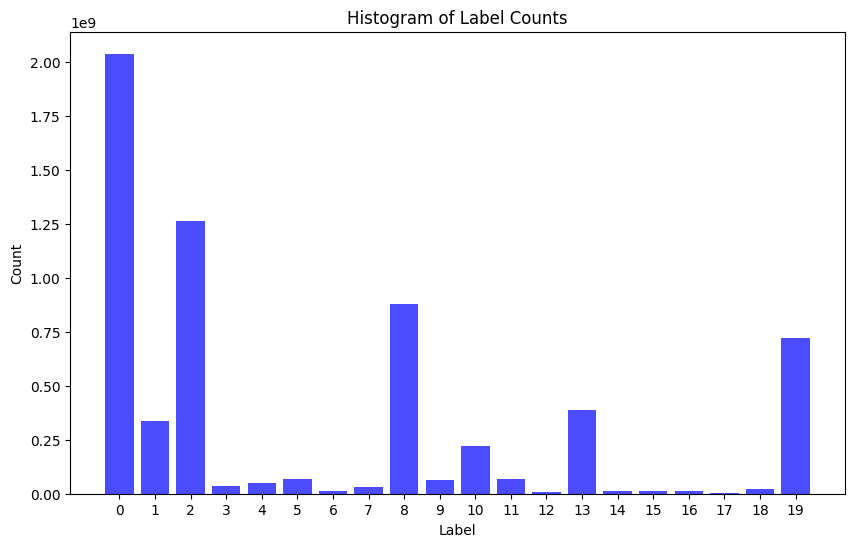

In [55]:
all_labels = list(range(len(sorted_counter)))
print(sorted_counter)
all_counts = [sorted_counter.get(label, 0) for label in all_labels]
all_counts[19]=sorted_counter.get(255)
# Print the counts for debugging
print(f"All counts: {all_counts}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(all_labels, all_counts, color='blue', alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Label Counts')
plt.xticks(all_labels)  # Ensure x-axis shows all labels
plt.show()

In [58]:
# Compute class weights
total_count = sum(label_counts.values())
num_classes = len(label_counts)
class_weights = {label: total_count / count for label, count in label_counts.items()}
print(sorted(class_weights))
sorted_weights = OrderedDict(dict(sorted(class_weights.items())))
print(sorted_weights)
weights = [sorted_weights.get(i,0) for i in range(num_classes)]
weights[19] = sorted_weights.get(255,0)
weights_tensor = torch.tensor(weights, dtype=torch.float)
print(weights_tensor)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 255]
OrderedDict({0: 3.064281538610771, 1: 18.566859829315682, 2: 4.952498298625009, 3: 172.29553457155998, 4: 128.6733052233194, 5: 92.05931994000751, 6: 542.0340584256129, 7: 204.408367149245, 8: 7.100028096369523, 9: 97.53847969268337, 10: 28.172354362059593, 11: 92.83937722385164, 12: 838.0262104012851, 13: 16.142251972753634, 14: 422.2690415333193, 15: 480.08030902909474, 16: 485.0015687271979, 17: 1145.6355954533944, 18: 273.0456337396979, 255: 8.684206067786866})
tensor([   3.0643,   18.5669,    4.9525,  172.2955,  128.6733,   92.0593,
         542.0341,  204.4084,    7.1000,   97.5385,   28.1724,   92.8394,
         838.0262,   16.1423,  422.2690,  480.0803,  485.0016, 1145.6356,
         273.0456,    8.6842])


In [62]:
weight_array_normalized = weights_tensor / weights_tensor.sum()
print("Normalized Weight Array:", weight_array_normalized)

Normalized Weight Array: tensor([0.0006, 0.0037, 0.0010, 0.0340, 0.0254, 0.0182, 0.1071, 0.0404, 0.0014,
        0.0193, 0.0056, 0.0183, 0.1656, 0.0032, 0.0834, 0.0949, 0.0958, 0.2264,
        0.0540, 0.0017])


In [63]:
torch.save(weights_tensor, 'sorted_weights.pt')
torch.save(weight_array_normalized,'Normalized_weights.pt')


In [76]:
loaded_tensor = torch.load('sorted_weights.pt')
# print("Loaded Tensor:")
# loaded_tensor[19]=0
print(loaded_tensor)

tensor(0.)
